Использование моделей АРСС
Использование моделей АРСС для предсказания и анализа временных рядов.
Библиотеки sktime, statsmodels, pmdarima. Выбор параметров для модели ARIMA.
Тесты на стационарность. Автоматические методы подбора параметров. Анализ
остатков. Особенности выбора параметров для модели SARIMA. Использование
экзогенных факторов – модель SARIMAX.

Импорт библиотек и данных.

Один из методов, доступных в Python для моделирования и прогнозирования временных
рядов,
известен
интегрированное скользящие средние с экзогенными регрессорами.
Классический подход к адаптации модели ARIMA - следовать методологии Бокса-
Дженкинса.

Идентификация модели: используйте графический метод и метод сводной
статистики для определения тренда и сезонности, чтобы получить представление
о порядке производной (d) и порядках модели (p – порядок авторегрессии и q –
порядок скользящего среднего).

Оценка модели: оценка коэффициентов регрессионной модели.


Диагностика модели максимального правдоподобия: используйте графический
метод
и
статистические
тесты
остаточных
ошибок,
чтобы
определить
особенности данных, не охваченной моделью.

In [2]:
!pip install sktime 
!pip install pmdarima
#!pip install tbats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 97.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_squared_error
import pmdarima as pm

In [4]:
import warnings

Мы будем работать с набором данных под названием «Атмосферные выбросы CO2 из
непрерывных проб воздуха в обсерватории Мауна-Лоа, Гавайи, США», который собирал
замеры выбросов CO2 с марта 1958 года по декабрь 2001 года..

In [5]:
dataset = sm.datasets.co2.load_pandas()
y_ = dataset.data
y_.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


Для начала произведем небольшую предварительную обработку данных.

In [7]:
# The 'MS' string groups the by start of the month
y = y_['co2'].resample('MS').mean()
# The term bfill means that we use the value before filling in missing val

y = y.fillna(y.bfill())
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

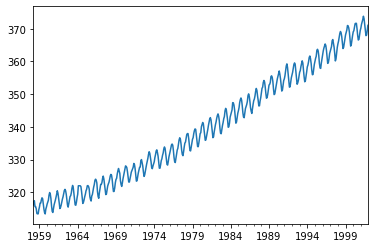

In [8]:
y.plot();

Когда
мы
наносим
данные
на
график,
появляются
некоторые
различимые
закономерности. Временной ряды имеют очевидную сезонность, а также общую
тенденцию к росту.

In [9]:
y.describe()

count    526.000000
mean     339.624826
std       17.110954
min      313.400000
25%      324.025000
50%      337.912500
75%      354.537500
max      373.800000
Name: co2, dtype: float64

Исследование модели ARIMA

Один из наиболее распространенных методов, используемых при прогнозировании
временных рядов, известен как модель ARIMA, что означает AutoregRessive Integrated

Moving Average. Существует три различных параметра (порядка) с целыми значениями

(p, d, q), которые используются для параметризации моделей ARIMA. По этой причине

модели ARIMA обозначаются обозначением ARIMA (p, d, q):

p - авторегрессивная часть модели. Этот параметр позволяет учесть влияние
прошлых значений на текущее для модели. Прошлые значения здесь называются
запаздывающими наблюдениями (также известными как «запаздывание» или
«лаг»). Интуитивно это похоже на утверждение, что завтра, вероятно, будет тепло,
если в последние 3 дня было тепло. Другими словами, здесь мы можем сказать, что
наше текущее значение температуры зависит от последних трех значений.

d – интегрирование модели. Этот параметр включает в себя степень различия
лагов (то есть количество прошлых временных точек, которые нужно вычесть из
текущего значения), чтобы сделать временной ряд стационарным (чтобы
исключить часть тренда). Интуитивно это было бы похоже на утверждение о том,
что, вероятно, будет одно и то же повышение температуры каждый день (или
одно и то же ускорение для второй производной и т.д.).

q - скользящая средняя часть модели. Этот параметр позволяет представить
остаточную часть (шум, ошибку) модели как линейную комбинацию остаточных
значений, наблюдаемых в предыдущие моменты времени.

Ручной выбор параметров модели ARIMA

Для начала рассмотрим порядок дифференцирования для тостижения стационарности.
Как правило, это 1-3 порядок, реже - больше.

Для проверки стационарности здесь мы будем использовать два метода:

Скользящая
статистика:
построение
скользящего
среднего
и
скользящего
стандартного отклонения. Идея этого метода в том, что временные ряды
являются стационарными, если они остаются неизменными во времени.


Расширенный тест Дики-Фуллера: временной ряд считается стационарным, если
значение p низкое (в соответствии с нулевой гипотезой), а критические значения
с доверительными интервалами 1%, 5%, 10% максимально близки к статистике
ADF.

Скользящая статистика визуально показывает нестационарность среднего значения. А
также мы видим уменьшение дисперсии.

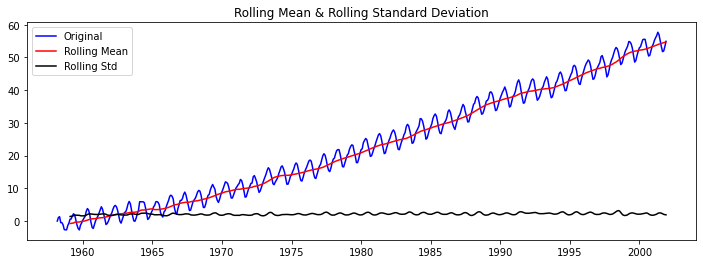

In [10]:
rolling_mean = y.rolling(window = 12).mean()
rolling_std = y.rolling(window = 12).std()
plt.figure(figsize=(12,4))
plt.plot(y-y[0], color = 'blue', label = 'Original')
plt.plot(rolling_mean-y[0], color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Тест ADF также показывает, что статистика ADF далека от критических значений, а
значение p превышает пороговое значение (0,05). Таким образом, можно сделать вывод,
что временной ряд не является стационарным.

In [12]:
result = adfuller(y)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 2.3598099539953528
p-value: 0.9989901230798025
Critical Values:
	1%: -3.4432119442564324
	5%: -2.8672126791646955
	10%: -2.569791324979607


Теперь давайте посмотрим на 1ю производную

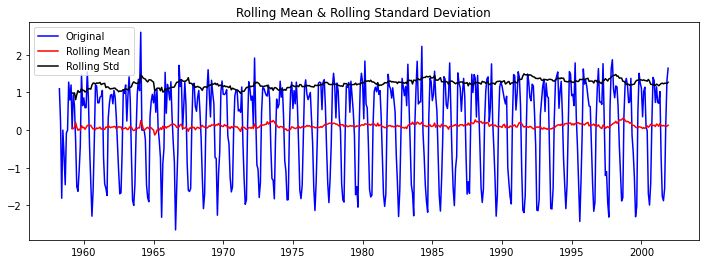

In [13]:
y_diff = y.diff(1)
# for fill obtained first NaN Value with next
y_diff = y_diff.dropna()
rolling_mean = y_diff.rolling(window = 12).mean()
rolling_std = y_diff.rolling(window = 12).std()
plt.figure(figsize=(12,4))
plt.plot(y_diff, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

Здесь и ниже мы видим, что наши данные теперь удовлетворяют стационарным
критериям.

In [14]:
y_diff.head()

1958-04-01    1.100000
1958-05-01    0.233333
1958-06-01   -1.808333
1958-07-01    0.000000
1958-08-01   -0.675000
Freq: MS, Name: co2, dtype: float64

In [15]:
result = adfuller(y_diff)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))

for key, value in result[4].items():
     print('\t{}: {}'.format(key, value))

ADF Statistic: -5.063202630318541
p-value: 1.6614851317682985e-05
	1%: -3.4432119442564324
	5%: -2.8672126791646955
	10%: -2.569791324979607


Примечание. Помимо ADF существует множество тестов, среди которых также полезно
проверить

Анализ ACF (АКФ) , в котором для нестационарного процесса вы увидите
медленное уменьшение значений АКФ, и резкий спад значений автокорреляции
для стационарного случая.


Тест Квятковского – Филлипса – Шмидта – Шина (KPSS), который дает значения,
отличающиеся от ADF в случае детерминированного тренда с точками перегиба.

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

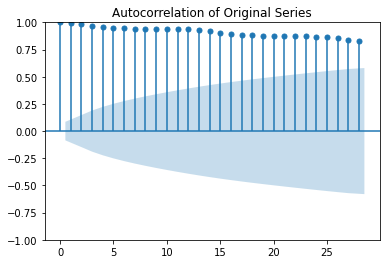

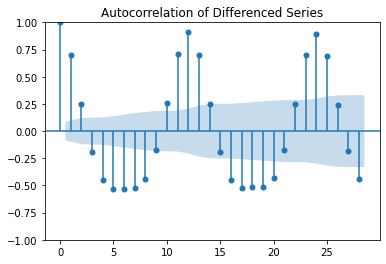

In [19]:
# Original Series
plot_acf(y[:], title='Autocorrelation of Original Series');plt.show()
# Usual Differencing
plot_acf(y_diff[:], title='Autocorrelation of Differenced Series');plt.show()
plt.show();

In [20]:
from statsmodels.tsa.stattools import kpss

In [21]:
def kpss_test(series, **kw):
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
# Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
      print(f' {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')  

In [22]:
kpss_test(y_diff)

KPSS Statistic: 0.8207294784328789
p-value: 0.01
num lags: 11
Critial Values:
 10% : 0.347
 5% : 0.463
 2.5% : 0.574
 1% : 0.739
Result: The series is not stationary


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Примечание. Если ваш ряд немного недодифференцирован, то необходимо будет
добавить один или несколького дополнительных слогаемых в авторегрессионную 


(повысить порядок) обычно это компенсирует. Аналогичным образом, если разница
немного выше, попробуйте добавить дополнительный член к скользящиму средниму.
После выбора порядка интеграции необходимо выбрать порядки AR и MA частей. Для
этого могут быть даны следующие рекомендации по этому поводу

Чтобы оценить порядок авторегрессии (порядок AR), проанализируйте график
частичной
автокорреляции
(PACF).
Как
правило,
график
состоит
из
доверительных интервалов, которые отображаются в виде конуса. По умолчанию
установлен доверительный интервал 95%, что предполагает, что значения
корреляции за пределами этого интервала, скорее всего, являются корреляцией,
а не статистической случайностью.

После оценки AR мы можем сделать первоначальное предположение о порядке
скользящего среднего (порядок MA). Для этого нужно будем использовать график
автокорреляции (ACF). Число ненулевых членов ACF сообщает, сколько членов MA
необходимо для устранения любой автокорреляции в стационарном ряду.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


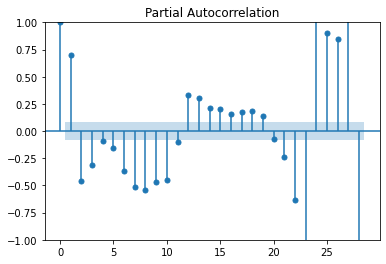

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y_diff);
plt.show()

График PACF показывает, что у нас есть как минимум модель AR 1-го порядка с
некоторыми
дополнительными
эффектами,
такими
как
сезонность
или
стационарность.
Примечание. График начинается с лага- 0, поэтому мы не можем его учитывать.

Примечание. График начинается с лага- 0, поэтому мы не можем его учитывать.

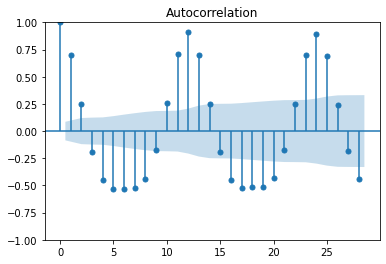

In [24]:
plot_acf(y_diff);
plt.show()

In [25]:
#Давайте протестируем выбранную модель ARMA(p=1,d=1,q=2).
from statsmodels.tsa.arima.model import ARIMA
# 1,1,2 ARIMA Model
model = ARIMA(y.values, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  526
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -607.411
Date:                Fri, 10 Mar 2023   AIC                           1222.822
Time:                        19:17:58   BIC                           1239.876
Sample:                             0   HQIC                          1229.500
                                - 526                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4018      0.073      5.529      0.000       0.259       0.544
ma.L1          0.5221      0.072      7.241      0.000       0.381       0.663
ma.L2          0.3636      0.057      6.379      0.0

Выведенное описание модели раскрывает много информации. В первой таблице
представлена общая информация, включая критерии качества (AIC, BIC и HQIC). Таблица
посередине - это таблица коэффициентов, где значения под «coef» - это веса
соответствующих слогаемых. Значение sigma2 – это RSS ошибка модели. В последней
таблице представлены результаты различных статистических тестов для полученных
остатков.

Помимо табличного представления, мы можем проводить диагностику остатков
графическим способом.

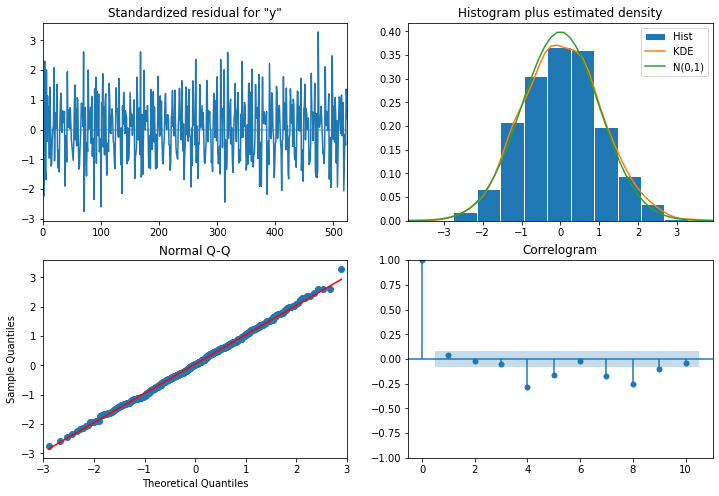

In [26]:
model_fit.plot_diagnostics(figsize=(12,8));

На графиках выше мы видим: остаточные ошибки колеблются около нулевого среднего
и имеют равномерную дисперсию (верхний левый график). Остаток имеет почти
нормальное распределение (верхний правый график). График Q-Q также показывает
почти нормальное распределение (внизу слева, в идеале все точки должны точно
совпадать с красной линией). Однако на графике ACF (коррелограмме) мы можем
заметить некоторые выбросы, превышающие уровень доверительного интервала
(внизу справа, любая автокорреляция будет означать, что существует некоторая
закономерность в остаточных ошибках, которые не объясняются в модели).

Проведенный анализ показывает, что мы можем улучшить нашу модель. В качестве
первого предположения мы можем попытаться увеличить AR-порядок модели.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  526
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -533.373
Date:                Fri, 10 Mar 2023   AIC                           1076.745
Time:                        19:20:23   BIC                           1098.062
Sample:                             0   HQIC                          1085.092
                                - 526                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5539      0.034     45.970      0.000       1.488       1.620
ar.L2         -0.8466      0.038    -22.003      0.000      -0.922      -0.771
ma.L1         -0.8716      0.059    -14.654      0.0

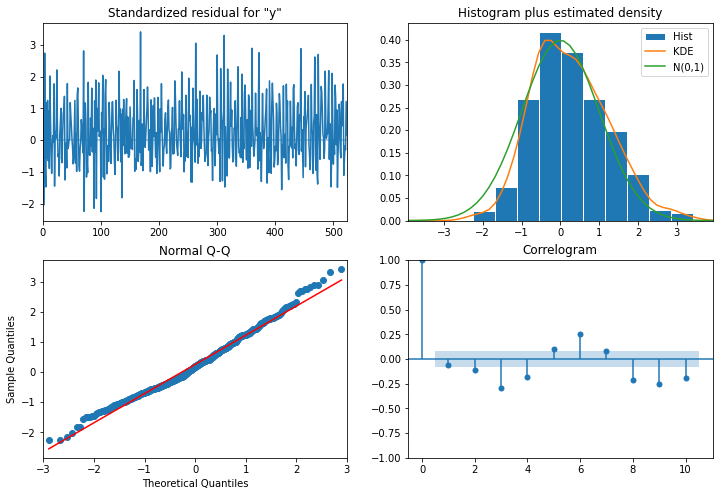

In [27]:
from statsmodels.tsa.arima.model import ARIMA
# 1,1,2 ARIMA Model
model = ARIMA(y.values, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(12,8));

Как мы видим здесь, мы уменьшаем значения как критериев AIC (и BIC), так и ошибку
RSS (sigma2) - это означает, что мы движемся в правильном направлении. Однако мы
немного ухудшили поведение остатков . Поиск лучших параметров - сложная задача.
Здесь мы также можем заметить, что у нас есть небольшое значение компоненты ma.L2,
и можем попробовать его устранить.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  526
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -533.989
Date:                Fri, 10 Mar 2023   AIC                           1075.978
Time:                        19:21:30   BIC                           1093.032
Sample:                             0   HQIC                          1082.656
                                - 526                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5353      0.028     55.566      0.000       1.481       1.589
ar.L2         -0.8285      0.030    -27.249      0.000      -0.888      -0.769
ma.L1         -0.8117      0.037    -21.901      0.0

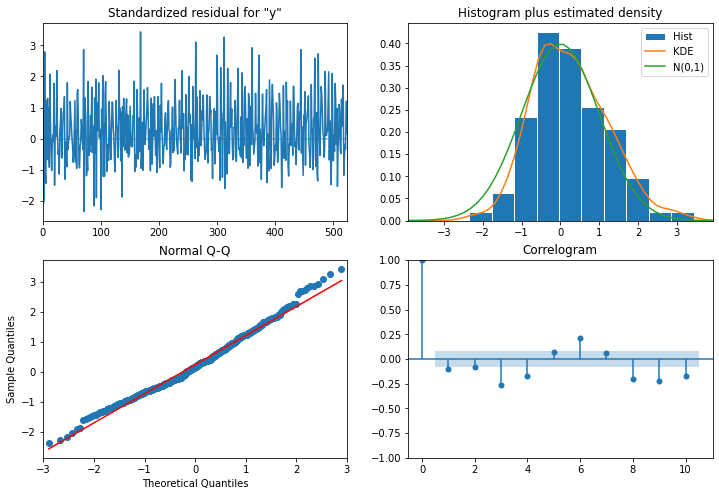

In [28]:
from statsmodels.tsa.arima.model import ARIMA
# 1,1,2 ARIMA Model
model = ARIMA(y.values, order=(2,1,1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(12,8));

Теперь мы видим, что действительно второй член не влияет на точность предсказания
данных.

Теперь мы можем построить график для подобранной модели. В следующем примере,
когда
вы
устанавливаете
dynamic
=
False,
для
прогнозирования
используются
запаздывающие значения в выборке. То есть модель обучается до предыдущего
значения, чтобы сделать следующий прогноз. Это может привести к тому, что
подогнанный прогноз и фактические данные будут выглядеть искусственно хорошими.

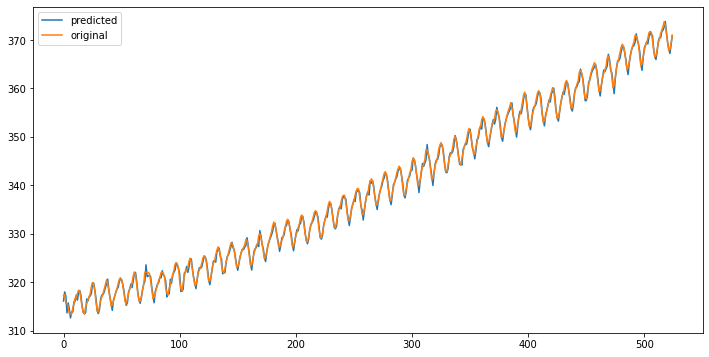

In [29]:
y_hat = model_fit.predict(dynamic=False)
plt.figure(figsize=(12,6))
plt.plot(y_hat[1:], label='predicted')
plt.plot(y[1:].values, label='original')
plt.legend()
plt.show()

Помимо построения модели по существующим данным, мы можем проверить модель
тестовых данных. Для этого мы можем разделить наши данные на две выборки -
тестовая и тренировочная.

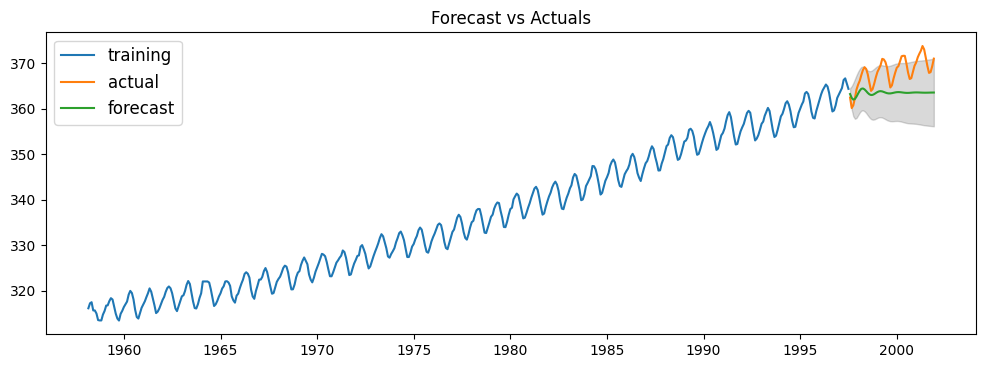

In [30]:
# Create Training and Test
train = y[:int(y.size*0.9)]
test = y[int(y.size*0.9):]
# Build Model
model = ARIMA(train, order=(2, 1, 1))
fitted = model.fit()
# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)
# 95% conf
# forecast = fitted.forecast(test.size, alpha=0.05) # 95% conf
forecast = forecast_res.predicted_mean
# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)
lower_series = pd.Series(forecast_res.conf_int()['lower co2'], index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'], index=test.index)

plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')


plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

Теперь мы видим, что наша модель была переобучена. Для оценки точности нашего
прогноза мы можем ввести следующие меры:

In [31]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
  mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
  me = np.mean(forecast - actual) # ME
  mae = np.mean(np.abs(forecast - actual)) # MAE
  mpe = np.mean((forecast - actual)/actual) # MPE
  rmse = np.mean((forecast - actual)**2)**.5 # RMSE
  corr = np.corrcoef(forecast, actual)[0,1] # corr
  mins = np.amin(np.hstack([forecast[:,None],
                            actual[:,None]]), axis=1)
  maxs = np.amax(np.hstack([forecast[:,None],
                            actual[:,None]]), axis=1)
  minmax = 1 - np.mean(mins/maxs) # minmax
  return({'mean absoute percentage error':mape,
          'mean absoute error ': mae,
          'mean percentage error ': mpe,
          'root mean square ':rmse,
          'correlation coefficient ':corr,
          'minmax error ':minmax})
forecast_accuracy(fc_series.values, test.values)

{'mean absoute percentage error': 0.012988020809680667,
 'mean absoute error ': 4.8005675325382935,
 'mean percentage error ': -0.012544452774340607,
 'root mean square ': 5.4134464107788745,
 'correlation coefficient ': 0.6297385621068393,
 'minmax error ': 0.012986996921779181}

Мы можем выбрать лучшие порядки модели, как показано ниже.

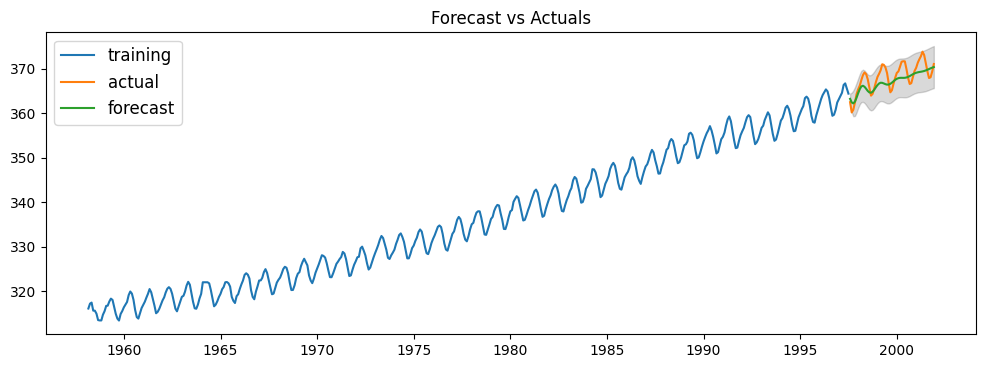

{'mean absoute percentage error': 0.005024784411266724,
 'mean absoute error ': 1.8554289221512499,
 'mean percentage error ': -0.003016313051680212,
 'root mean square ': 2.2142045862011552,
 'correlation coefficient ': 0.783720001915019,
 'minmax error ': 0.0050204354370601}

In [32]:
# Create Training and Test
train = y[:int(y.size*0.9)]
test = y[int(y.size*0.9):]
# Build Model
model = ARIMA(train, order=(3, 2, 2))
fitted = model.fit()
# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)
# 95% conf
forecast = forecast_res.predicted_mean
# forecast = fitted.forecast(test.size, alpha=0.05) # Alternative method
# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)
lower_series = pd.Series(forecast_res.conf_int()['lower co2'], index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'], index=test.index)
# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()
forecast_accuracy(fc_series.values, test.values)

Сейчас мы видим, что наши метрики стали значительно лучше.

Автоматические методы выбора порядка с помощью библиотеки pmdarima
Помимо ручного выбора параметров ARIMA, мы можем использовать автоматический
поиск arima с использованием библиотеки pmdarima.

In [33]:
import pmdarima as pm
model = pm.auto_arima(y,
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=10,
                      max_q=10, # maximum p and q
                      m=1, # frequency of series
                      d=None, # let model determine 'd'
                      seasonal=False, # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1268.116, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1676.811, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1328.472, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1374.168, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1678.850, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1010.848, Time=1.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1205.382, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1009.758, Time=2.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1150.521, Time=0.74 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1008.632, Time=1.41 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1149.017, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=947.702, Time=1.31 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1138.051, Time=0.23 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=833.411, Time=1.46 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  526
Model:              SARIMAX(10, 1, 2)   Log Likelihood                -234.103
Date:                Fri, 10 Mar 2023   AIC                            496.206
Time:                        19:30:18   BIC                            555.894
Sample:                    03-01-1958   HQIC                           519.578
                         - 12-01-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3071      0.028     11.097      0.000       0.253       0.361
ar.L1          0.7529      0.060     12.556      0.000       0.635       0.870
ar.L2         -0.8540      0.054    -15.956      0.000      -0.959      -0.749
ar.L3         -0.1083      0.060     -1.801      0.072      -0.226       0.010
ar.L4         -0.1940      0.061     -3.194      0.001      -0.313      -0.075
ar.L5         -0.2190      0.065     -3.381      0.001      -0.346      -0.092
ar.L6         -0.2280      0.065     -3.488      0.000      -0.356      -0.100
ar.L7         -0.2587      0.063     -4.112      0.000      -0.382      -0.135
ar.L8         -0.2486      0.064     -3.902      0.000      -0.373      -0.124
ar.L9         -0.2203      0.056     -3.950      0.000      -0.330      -0.111
ar.L10        -0.2002      0.052     -3.856      0.000      -0.302      -0.098
ma.L1         -0.8820      0.047    -18.628      0.000      -0.975      -0.789
ma.L2          0.7801      0.037     20.905      0.000       0.707       0.853
sigma2         0.1408      0.008     17.358      0.000       0.125       0.157
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 9.33
Prob(Q):                              0.94   Prob(JB):                         0.01
Heteroskedasticity (H):               0.64   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Автопоиск предлагает использовать модель ARIMA (10,1,2). Протестируем ее.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


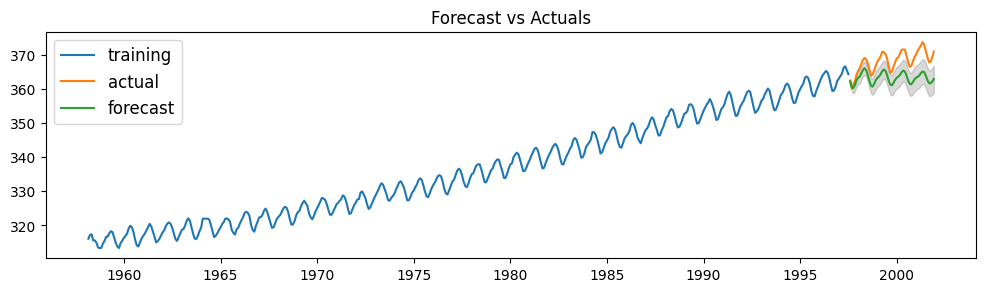

{'mean absoute percentage error': 0.013251292987510052,
 'mean absoute error ': 4.892906924099521,
 'mean percentage error ': -0.01319599555773823,
 'root mean square ': 5.314669099214099,
 'correlation coefficient ': 0.7607720217213495,
 'minmax error ': 0.013251252530868451}

In [34]:
# Create Training and Test
train = y[:int(y.size*0.9)]
test = y[int(y.size*0.9):]
# Build Model
model = ARIMA(train, order=(10, 1, 2))
fitted = model.fit()
# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)
# 95% conf
# forecast = fitted.forecast(test.size, alpha=0.05) # 95% conf
forecast = forecast_res.predicted_mean
# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)
lower_series = pd.Series(forecast_res.conf_int()['lower co2'], index=test.
index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'], index=test.
index)
# Plot
plt.figure(figsize=(12,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()
forecast_accuracy(fc_series.values, test.values)

Как мы видим, автопоиск не гарантирует лучших результатов в прогнозе. Это связано с
отсутствием перекрестной проверки, но мы, вероятно, сможем улучшить эту модель
вручную.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


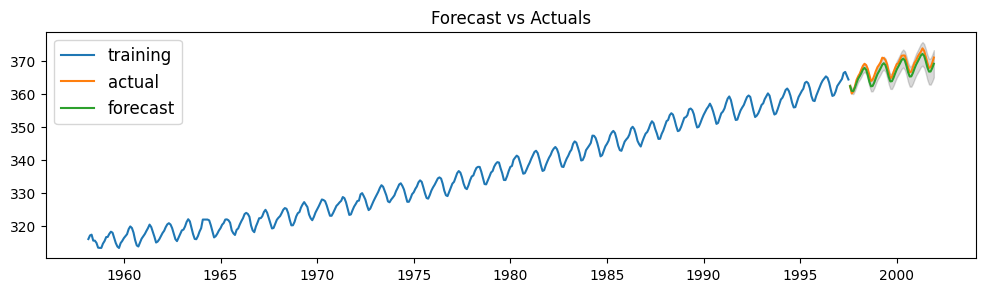

{'mean absoute percentage error': 0.003761076759981714,
 'mean absoute error ': 1.3860341653166783,
 'mean percentage error ': -0.003665225427801737,
 'root mean square ': 1.461117162479391,
 'correlation coefficient ': 0.9852016615196508,
 'minmax error ': 0.003760985532786365}

In [35]:
# Create Training and Test
train = y[:int(y.size*0.9)]
test = y[int(y.size*0.9):]
# Build Model
model = ARIMA(train, order=(10, 2,8))
fitted = model.fit()
# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)
# 95% conf
# forecast = fitted.forecast(test.size, alpha=0.05) # 95% conf
forecast = forecast_res.predicted_mean
# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)
lower_series = pd.Series(forecast_res.conf_int()['lower co2'], index=test.
                         index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'], index=test.
                         index)
# Plot
plt.figure(figsize=(12,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()
forecast_accuracy(fc_series.values, test.values)

Сезонная модель ARIMA (SARIMA)

Важность сезонной производной

Проблема с простой моделью ARIMA в том, что она не подразумевает нестационарную
сезонность. Если для временного ряда имеет место значительный эффект сезонности,
тогда следует выбирать модель SARIMA. В этой модели используются сезонные
производные.

Сезонная производная аналогична обычной производной, но вместо вычитания
последовательных членов вы вычитаете значение из предыдущего периода сезонности.

Примечания. При работе с сезонными эффектами мы используем сезонный ARIMA
(SARIMA), который обозначается как SARIMA (p, d, q) (P, D, Q) s. Здесь (p, d, q)
являются несезонными параметрами, описанными выше, а (P, D, Q) следуют тому
же порядку определений, но применяются к сезонной составляющей временного
ряда. Член s - это периодичность временного ряда (4 для квартальных периодов,
12 для годовых периодов и т.д.).

Для начала давайте посмотрим, как работает сезонное дифференцирование

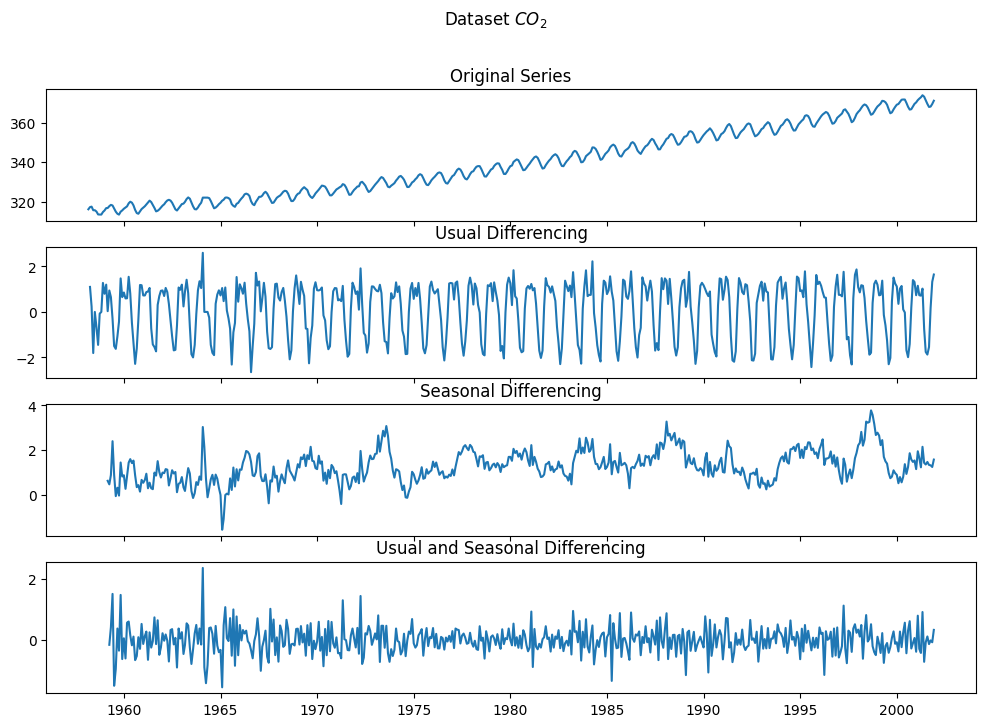

In [36]:
SEASON = 12
# Plot
fig, axes = plt.subplots(4, 1, figsize=(12,8), dpi=100, sharex=True)
# Original Series
axes[0].plot(y[:])
axes[0].set_title('Original Series')
# Usual Differencing
axes[1].plot(y[:].diff(1))
axes[1].set_title('Usual Differencing')
# Seasinal Differencing
axes[2].plot(y[:].diff(SEASON))
axes[2].set_title('Seasonal Differencing')
# Seasinal and Usual Differencing
axes[3].plot(y[:].diff(1).diff(SEASON))
axes[3].set_title('Usual and Seasonal Differencing')
plt.suptitle('Dataset $CO_2$', fontsize=12)
plt.show()

Как мы видим, сезонная разница может помочь сделать данные более стационарными.

Примечание. Как мы можем видеть на графике обычной разницы, у нас есть как
минимум две сезонные составляющие с разными периодами, но, взяв одну
сезонную разницу, мы исключаем почти все сезонные влияния. Посмотрим на
спектр.

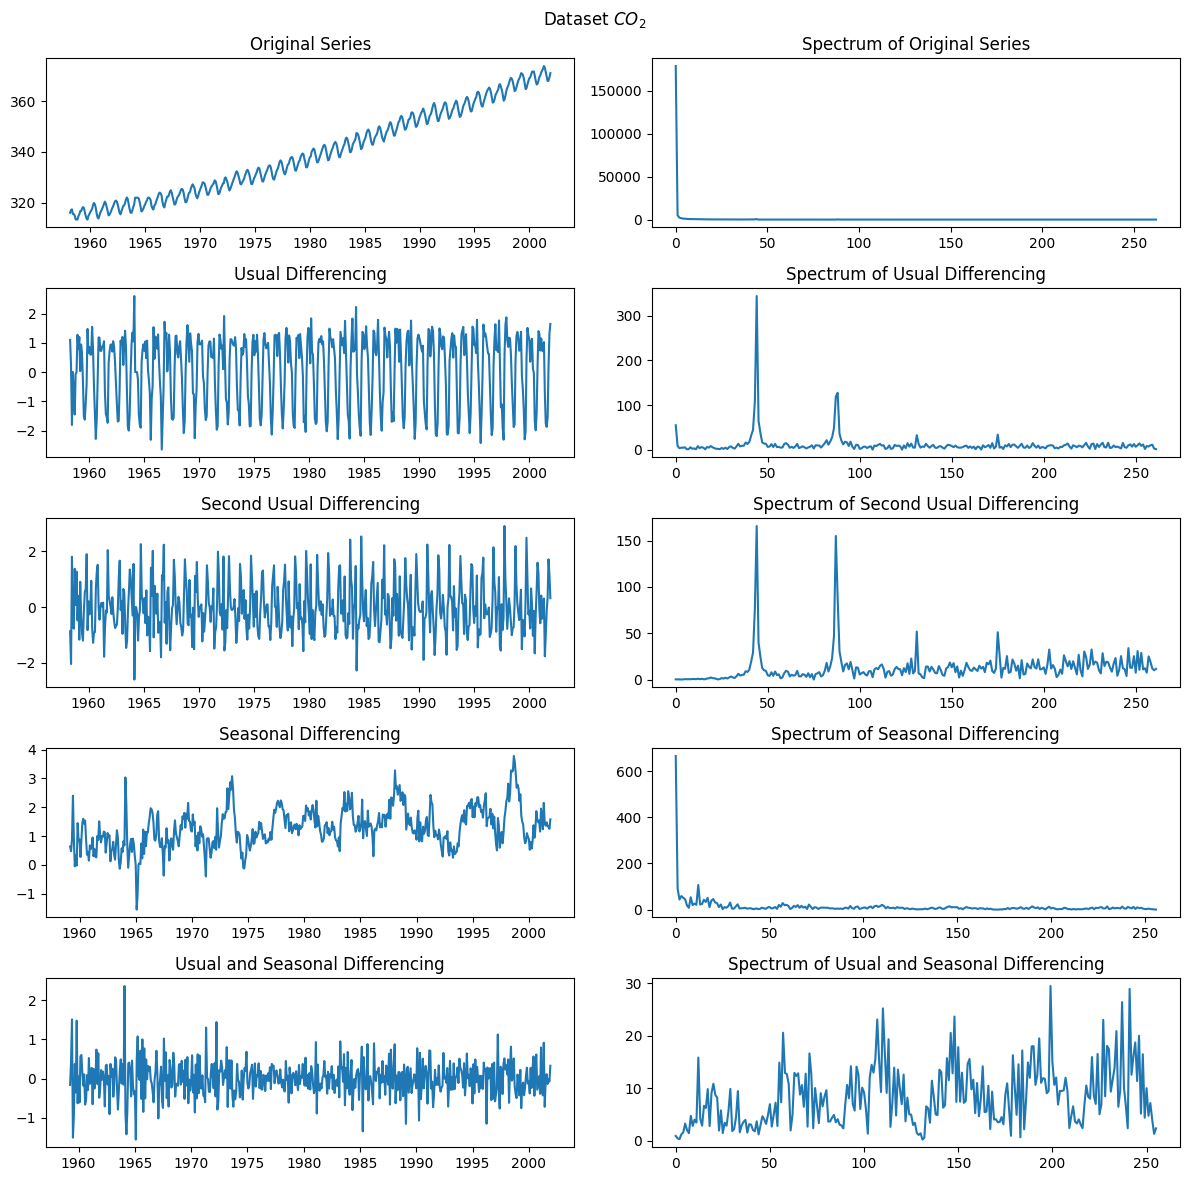

In [37]:
SEASON = 12
def afft(x):
  x_np = x.dropna().values
  return np.abs(np.fft.fft(x_np))[:x_np.size//2] # the spectrum is mirrored relative to the middle point
# Plot
fig, axes = plt.subplots(5, 2, figsize=(12,12), dpi=100)
# Original Series
axes[0,0].plot(y[:])
axes[0,0].set_title('Original Series')
axes[0,1].plot(afft(y))
axes[0,1].set_title('Spectrum of Original Series')
# Usual Differencing
axes[1,0].plot(y[:].diff(1))

axes[1,0].set_title('Usual Differencing')
axes[1,1].plot(afft(y.diff(1)))
axes[1,1].set_title('Spectrum of Usual Differencing')
# Usual Differencing
axes[2,0].plot(y[:].diff(1).diff(1))
axes[2,0].set_title('Second Usual Differencing')
axes[2,1].plot(afft(y.diff(1).diff(1)))
axes[2,1].set_title('Spectrum of Second Usual Differencing')
# Seasinal Differencing
axes[3,0].plot(y[:].diff(SEASON))
axes[3,0].set_title('Seasonal Differencing')
axes[3,1].plot(afft(y.diff(SEASON)))
axes[3,1].set_title('Spectrum of Seasonal Differencing')
# Seasinal and Usual Differencing
axes[4,0].plot(y[:].diff(1).diff(SEASON))
axes[4,0].set_title('Usual and Seasonal Differencing')
axes[4,1].plot(afft(y.diff(1).diff(SEASON)))
axes[4,1].set_title('Spectrum of Usual and Seasonal Differencing')
plt.suptitle('Dataset $CO_2$', fontsize=12)
fig.tight_layout()
plt.show()

Как мы видим на графиках выше, спектр обычной разности содержит по крайней мере 4
компоненты (пика), но все с одним и тем же шагом (то есть один с периодом 12,
следующий с периодом 24 и так далее). Благодаря этому используя разность с периодом
12 мы исключаем все сезонные составляющие на нижнем графике.

Также необходимо отметить, что тренд - это самая низкочастотная часть (см. Начало
спектра). Таким образом, мы практически исключаем влияние тренда. При этом
оставшуюся
часть
влияния
тренда
мы
исключаем,
беря
вторую
разницу.
Это
подтверждает наше предположение о необходимости дифференцирования порядка в
приведенных выше примерах.

Выбор порядка модели SARIMA

В объяснении выше мы отметили, что сезонная разница делает данные более
стационарными. Затем нам нужно выбрать наилучшее начальное предположение о
порядках модели SARIMA.

Правила выбора начальных порядков

Правильный порядок d - это порядок дифференцирования, который дает
временной ряд с шумоподобным поведением, т.е. случайные колебания около
четко
определенного
среднего
значения
с
почти
постоянным
разбросом,
проверьте на стационарность по критериям, указанным выше. Если временной
ряд имеет положительные значения ACF с большим значением лага добавить
обычную производную.

Используйте сезонную производную D только в случае сильного влияния
сезонности для модели.

Количество слагаемых AR (порядок) определяется как последнее значение лага
PACF перед быстрым уменьшением от положительных значений до нуля.

Количество слагаемых скользящего среднего (MA) определяется как последнее
значение лага ACF перед быстрым увеличением от отрицательных значений до
нуля.

Добавьте слагаемое SAR, если значения ACF периодически положительная.
Помимо этого, порядок SAR может быть оценен из PACF.
 Посмотрите на
количество значений лагов, которые кратны периоду сезона. Например, если
период равен 24, и мы видим, что 24-е и 48-е запаздывания значительны в PACF,
это означает, что начальное P должно быть 2
Добавьте
член
SMA,
если
значения
ACF
периодически
отрицательный.

Используйте те же правила определения количества лагов, что и для SAR.
Если
ваш
временной
ряд
немного
недодифференцирован,
добавьте
дополнительное слагаемое в AR.

Если ваши ряды немного передифференцирован, добавьте дополнительные
слагаемое в MA.

Старайтесь избегать использования более одного или двух сезонных порядков
(SAR + SMA) в одной модели, так как это может привести к переобучению данных
и/или проблемам в точности оценок.

In [38]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train,
                       start_p=10, #Search for Usual AR order
                       start_q=1, #Search for Usual MA order
                       test='adf',
                       max_p=10,
                       max_q=10,
                       d=None, #Search for Usual Difference Order
                       m=12, #The period for seasonal differencing
                       seasonal=True, #SARIMA ENABLE
                       start_P=0, #Search for Seasonal AR order
                       start_Q=0, #Search for Seasonal MA order
                       D=None, #Search for Seasonal Difference Order
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(10,1,1)(0,0,0)[12] intercept   : AIC=519.756, Time=5.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1500.491, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1025.470, Time=0.44 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1502.018, Time=0.05 sec
 ARIMA(10,1,1)(1,0,0)[12] intercept   : AIC=512.311, Time=7.43 sec
 ARIMA(10,1,1)(2,0,0)[12] intercept   : AIC=483.706, Time=19.09 sec
 ARIMA(10,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=16.89 sec
 ARIMA(10,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=8.28 sec
 ARIMA(9,1,1)(2,0,0)[12] intercept   : AIC=481.730, Time=13.93 sec
 ARIMA(9,1,1)(1,0,0)[12] intercept   : AIC=564.277, Time=5.24 sec
 ARIMA(9,1,1)(2,0,1)[12] intercept   : AIC=434.807, Time=18.86 sec
 ARIMA(9,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=6.78 sec
 ARIMA(9,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=36.28 sec
 ARIMA(9,1,1)(1,0,2)[12] intercept   : A

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  473
Model:             SARIMAX(6, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -160.354
Date:                              Fri, 10 Mar 2023   AIC                            342.708
Time:                                      19:59:21   BIC                            388.435
Sample:                                  03-01-1958   HQIC                           360.695
                                       - 07-01-1997                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3958      0.046     30.158      0.000       1.305       1.487
ar.L2         -0.6261      0.067     -9.319      0.000      -0.758      -0.494
ar.L3         -0.2146      0.044     -4.835      0.000      -0.302      -0.128
ar.L4          0.1131      0.010     11.128      0.000       0.093       0.133
ar.L5         -0.0679      0.011     -5.941      0.000      -0.090      -0.046
ar.L6         -0.0936      0.015     -6.259      0.000      -0.123      -0.064
ma.L1         -1.7160      0.024    -71.757      0.000      -1.763      -1.669
ma.L2          0.9640      0.022     44.289      0.000       0.921       1.007
ar.S.L12       0.9983      0.002    629.603      0.000       0.995       1.001
ma.S.L12      -0.8848      0.040    -22.067      0.000      -0.963      -0.806
sigma2         0.1050      0.005     19.097      0.000       0.094       0.116
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                81.09
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Метод автопоиска дал порядок модели SARIMAX(6, 1, 2)x(1, 0, [1, 2], 12)

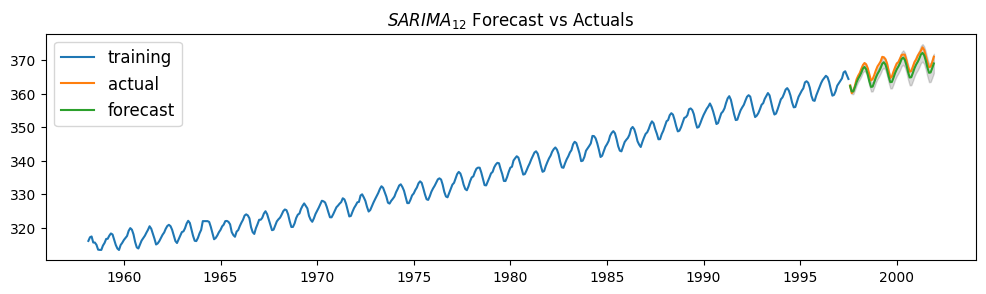

{'mean absoute percentage error': 0.004096985342466343,
 'mean absoute error ': 1.5096639065269486,
 'mean percentage error ': -0.004043212301594975,
 'root mean square ': 1.5899742940247958,
 'correlation coefficient ': 0.9843992665711648,
 'minmax error ': 0.004096947084079927}

In [39]:
fitted, confint = smodel.predict(n_periods=test.size,
                                 return_conf_int=True)
# make series for plotting purpose
fc_series = pd.Series(fitted, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)
plt.title('$SARIMA_{12}$ Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()
forecast_accuracy(fc_series.values, test.values)

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


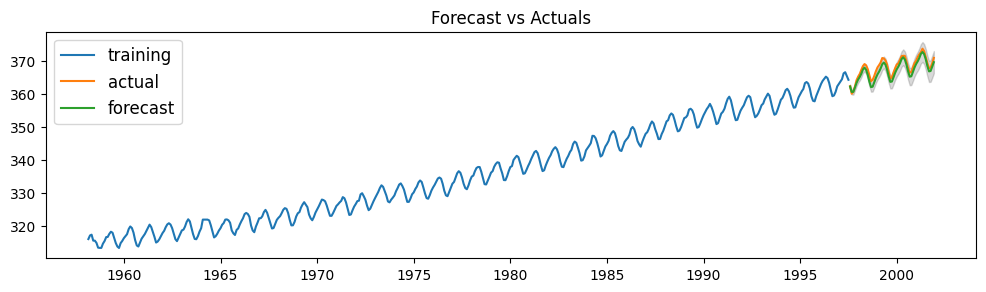

{'mean absoute percentage error': 0.0032071944625333975,
 'mean absoute error ': 1.1809917021060832,
 'mean percentage error ': -0.0031502287664517807,
 'root mean square ': 1.273172669570453,
 'correlation coefficient ': 0.985057304661816,
 'minmax error ': 0.00320715152989437}

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = sm.tsa.statespace.SARIMAX(train,order=(10, 2, 8),
                                  seasonal_order=(1, 1, 2, 12))
fitted = model.fit()
# Forecast
forecast_res = fitted.get_forecast(test.size, alpha=0.05, dynamic=False)
# 95% conf
# forecast = fitted.forecast(test.size, alpha=0.05) # 95% conf
forecast = forecast_res.predicted_mean
# Make as pandas series
fc_series = pd.Series(forecast.values, index=test.index)
lower_series = pd.Series(forecast_res.conf_int()['lower co2'],
                         index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper co2'],
                         index=test.index)


# Plot
plt.figure(figsize=(12,3), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()
forecast_accuracy(fc_series.values, test.values)

Модель SARIMAX (SARIMA с экзогенными регрессорами)


В некоторых случаях мы можем повысить точность прогноза модели, введя экзогенную
переменную. Основным требованием для использования экзогенной переменной
является то, что вам необходимо знать значение переменной в течение тренировочной
выборки и в период прогноза. В целом экзогенная переменная может быть какой угодно,
независимо от обучающих данных.


Для примера в наших примерах мы можем извлечь компонент сезона из тестовых
данных и рассматривать его как экзогенную переменную для обучающих данных. Мы
сделаем это с помощью процедуры Season_decompose.

In [42]:
#ReSample to DataFrame
y = y_['co2'].resample('MS').mean()
# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())
ydf = pd.DataFrame(y)
ydf.columns = ['endog']

Создадим новую выборку co2 как тренировочную (endog) и создадим экзогенную
выборку (exog)

In [43]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
y = y_['co2'].resample('MS').mean()
# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())
ydf = pd.DataFrame(y)
ydf.columns = ['endog']
ydf.head()
# multiplicative seasonal component
result_mul = seasonal_decompose(ydf.endog, # 3 years
                                model='multiplicative')
seasonal_index = result_mul.seasonal[-24:].to_frame()

seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month
# merge with the base data
ydf['month'] = ydf.index.month
ydf = pd.merge(ydf, seasonal_index, how='left', on='month')
ydf.columns = ['endog', 'month', 'exog']

ydf.head(12)

,endog,month,exog
0,316.100000,3,1.004239
1,316.100000,3,1.004239
2,317.200000,4,1.007380
3,317.200000,4,1.007380
4,317.433333,5,1.008577
5,317.433333,5,1.008577
6,315.625000,6,1.006689
7,315.625000,6,1.006689
8,315.625000,7,1.002177
9,315.625000,7,1.002177


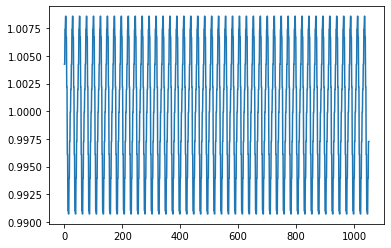

In [44]:
ydf.exog.plot();

In [45]:
train , test = pm.model_selection.train_test_split(ydf,test_size=0.1)

In [46]:
# Seasonal - fit stepwise auto-ARIMA
sxmodel = pm.auto_arima(train.endog,
                        exogenous = train.exog.values.reshape(-1,1),
                        start_p=10, #Search for Usual AR order
                        start_q=1, #Search for Usual MA order
                        test='adf',
                        max_p=10,
                        max_q=10,
                        d=None, #Search for Usual Difference Order
                        m=12, #The period for seasonal differencing
                        seasonal=True, #SARIMA ENABLE
                        start_P=0, #Search for Seasonal AR order
                        start_Q=0, #Search for Seasonal MA order
                        D=None, #Search for Seasonal Difference Order
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(10,0,1)(0,0,0)[12] intercept   : AIC=1335.963, Time=7.83 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=7802.641, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.97 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=6028.692, Time=0.76 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13696.893, Time=0.02 sec
 ARIMA(10,0,1)(1,0,0)[12] intercept   : AIC=1156.012, Time=16.27 sec
 ARIMA(10,0,1)(2,0,0)[12] intercept   : AIC=464.132, Time=36.87 sec
 ARIMA(10,0,1)(2,0,1)[12] intercept   : AIC=450.526, Time=33.58 sec
 ARIMA(10,0,1)(1,0,1)[12] intercept   : AIC=923.936, Time=22.79 sec
 ARIMA(10,0,1)(2,0,2)[12] intercept   : AIC=147.632, Time=57.33 sec
 ARIMA(10,0,1)(1,0,2)[12] intercept   : AIC=883.678, Time=17.21 sec
 ARIMA(9,0,1)(2,0,2)[12] intercept   : AIC=180.033, Time=33.12 sec
 ARIMA(10,0,0)(2,0,2)[12] intercept   : AIC=158.232, Time=29.21 sec
 ARIMA(10,0,2)(2,0,2)[12] intercept   : AIC=inf, Time=35.06 sec
 ARIMA(9,0,0)(2,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  946
Model:             SARIMAX(9, 0, 0)x(2, 0, [1, 2], 12)   Log Likelihood                 -57.183
Date:                                 Fri, 10 Mar 2023   AIC                            144.366
Time:                                         20:11:41   BIC                            217.150
Sample:                                              0   HQIC                           172.103
                                                 - 946                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0030      0.034      0.090      0.928      -0.063       0.069
ar.L1          1.0220      0.485      2.107      0.035       0.072       1.973
ar.L2         -0.3814      0.485     -0.786      0.432      -1.333       0.570
ar.L3          0.3540      0.688      0.514      0.607      -0.995       1.703
ar.L4         -0.1643      0.688     -0.239      0.811      -1.513       1.184
ar.L5          0.1742      0.879      0.198      0.843      -1.549       1.897
ar.L6         -0.2874      0.878     -0.327      0.744      -2.009       1.434
ar.L7          0.2868      0.847      0.339      0.735      -1.374       1.947
ar.L8         -0.1147      0.847     -0.135      0.892      -1.774       1.545
ar.L9          0.1104      0.024      4.592      0.000       0.063       0.157
ar.S.L12      -0.0135      0.005     -2.851      0.004      -0.023      -0.004
ar.S.L24       0.9837      0.005    209.763      0.000       0.974       0.993
ma.S.L12       0.0522      0.027      1.954      0.051      -0.000       0.104
ma.S.L24      -0.7334      0.026    -27.891      0.000      -0.785      -0.682
sigma2         0.0617      0.002     35.101      0.000       0.058       0.065
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):              2388.22
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Попробуем предсказание.

In [48]:
ex4test = pd.DataFrame(test.exog)
ex4test.head()

,exog
946,0.996102
947,0.996102
948,0.991034
949,0.991034
950,0.990717


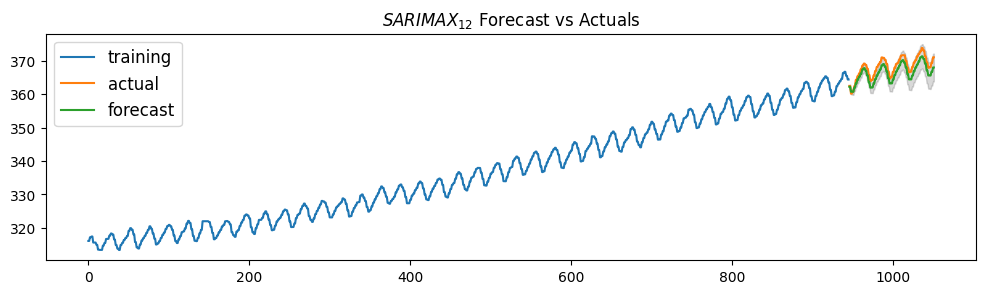

<ipython-input-31-df40357c8d5f>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-31-df40357c8d5f>:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


{'mean absoute percentage error': 0.005220810721277836,
 'mean absoute error ': 1.925010250144909,
 'mean percentage error ': -0.005160659336330085,
 'root mean square ': 2.0279990313421656,
 'correlation coefficient ': 0.9789368387665265,
 'minmax error ': 0.005220762855451477}

In [49]:
fitted, confint = sxmodel.predict(n_periods=np.shape(test.exog.values)[0],
                                  exogenous=ex4test,
                                  return_conf_int=True)
# make series for plotting purpose
fc_series = pd.Series(fitted, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,3), dpi=100)
plt.plot(train.endog, label='training')
plt.plot(test.endog, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)
plt.title('$SARIMAX_{12}$ Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()
forecast_accuracy(fc_series.values, test.endog)

Теперь попробуем модель SARIMAX из statsmodels.

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


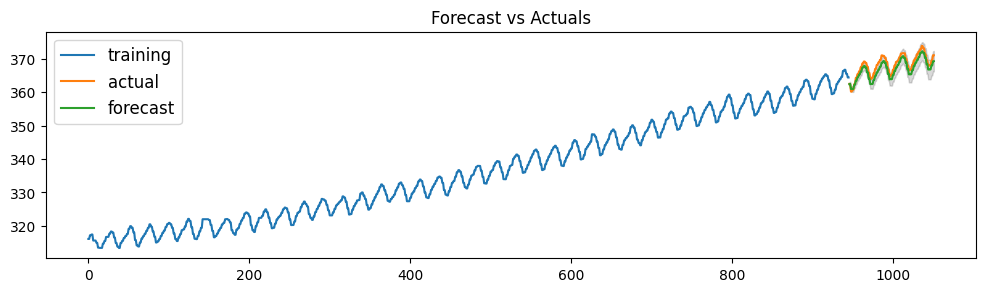

{'mean absoute percentage error': 0.003699225948558174,
 'mean absoute error ': 1.3634379450814027,
 'mean percentage error ': -0.0035948701236159513,
 'root mean square ': 1.4398509191308881,
 'correlation coefficient ': 0.9855050457862705,
 'minmax error ': 0.0036991272625008786}

In [51]:

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = sm.tsa.statespace.SARIMAX(endog=train.endog,
                                  exog =train.exog,
                                  order=(8, 2, 8),
                                  seasonal_order=(0, 0, 1, 12))
fitted = model.fit()
# Forecast
forecast_res = fitted.get_forecast(test.endog.size,
                                   exog = test.exog,
                                   alpha = 0.05,
                                   dynamic = False) # 95% conf
forecast = forecast_res.predicted_mean
# Make as pandas series
fc_series = pd.Series(forecast.values,
                      index=test.index)
lower_series = pd.Series(forecast_res.conf_int()['lower endog'], 
                         index=test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper endog'],
                         index=test.index)
# Plot
plt.figure(figsize=(12,3), dpi=100)
plt.plot(train.endog, label='training')
plt.plot(test.endog, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k',
                 alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=12)
plt.show()

forecast_accuracy(fc_series.values, test.endog.values)

Для нашего игрушечного случая мы не получили большого прироста точности, вероятно
это связано с тем, что экзогенные данные выбраны из той же выборки, что и
тренировочные, и не вносят новой информации.